In [3]:
import pandas as pd
import os
import pandas as pd
import pickle as pkl
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import datetime as dt
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

plt.style.use('../../fire_style.mplstyle')

## Reports

| Column Name                      | Description                                                                                             |
|---------------------------------|---------------------------------------------------------------------------------------------------------|
| **INC209R_IDENTIFIER**           | A unique identifier for the report.                                                                     |
| **INC_IDENTIFIER**               | An identifier for the incident linked to the report. Foreign key to incidents                           |
| **REPORT_FROM_DATE**             | The starting date and time of the report period.                                                        |
| **REPORT_TO_DATE**               | The ending date and time of the report period.                                                          |
| **STATUS**                       | The status of the report, like 'Initial', 'Under Control', 'Final',                                   |
| **CURR_INCIDENT_AREA**           | The current area (usually in acres or hectares) affected by the incident as of the report date.           |
| **PCT_CONTAINED_COMPLETED**      | The percentage of the incident that is contained or completed.                                          |
| **COMPLEXITY_LEVEL_IDENTIFIER**  | An identifier indicating the complexity level of the incident.                                           |
| **FUEL_MODEL_IDENTIFIER**        | An identifier indicating the primary fuel type or model driving the fire (e.g., grass, brush, timber).   |
| **PROJ_INCIDENT_AREA**           | The projected total area the incident will affect (if it's not already contained).                       |
| **PROJ_INC_AREA_UOM_IDENTIFIER** | Unit of measurement for the projected incident area (e.g., acres, hectares).                            |
| **ANTICIPATED_COMPLETION_DATE**  | The estimated date by which the incident is expected to be fully addressed or managed.                   |
| **EXPECTED_CONTAINMENT_DATE**    | The estimated date by which the incident is expected to be fully contained.                              |
| **PCT_PERIM_TO_BE_CONTAINED**    | The percentage of the incident's perimeter yet to be contained.                                          |
| **SECNDRY_FUEL_MODEL_IDENTIFIER**| An identifier indicating the secondary fuel type or model present in the fire's environment.             |
| **ADDNTL_FUEL_MODEL_IDENTIFIER** | An identifier for additional or tertiary fuel types or models in the fire's vicinity.                    |
| **GEN_FIRE_BEHAVIOR_IDENTIFIER** | An identifier describing the general fire behavior (e.g., smoldering, running, torching).               |
| **FIRE_BEHAVIOR_1_IDENTIFIER**   | An identifier for a specific fire behavior observed or predicted.                                       |
| **FIRE_BEHAVIOR_2_IDENTIFIER**   | Another identifier for a specific fire behavior, if multiple behaviors are observed or predicted.       |
| **FIRE_BEHAVIOR_3_IDENTIFIER**   | Yet another identifier for a specific fire behavior, if more than two behaviors are observed/predicted. |



In [4]:
from dateutil.parser import parse
def format_date(date_str):
    try:
        date_obj = parse(date_str)
        return date_obj.strftime('%Y-%m-%d %H:%M:%S')
    except:
        return None


In [6]:
df = pd.read_csv('../../data/raw/reports.csv')

C:\Users\benja\AppData\Local\Temp\ipykernel_21620\2870729536.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../data/raw/reports.csv')


In [ ]:
df.INC_IDENTIFIER.nunique()

7823

In [84]:
def convert_dates(df):
  print(f"Initial nans pcts FROM_DATE: {df['REPORT_FROM_DATE'].isna().sum()}")
  df['REPORT_FROM_DATE'] = pd.to_datetime(df['REPORT_FROM_DATE'].apply(format_date))
  print(f"Final nans pcts FROM_DATE: {df['REPORT_FROM_DATE'].isna().sum()}")
  print(f"Initial nans pcts TO_DATE: {df['REPORT_TO_DATE'].isna().sum()}")
  df['REPORT_TO_DATE'] = pd.to_datetime(df['REPORT_TO_DATE'].apply(format_date))
  print(f"Final nans pcts TO_DATE: {df['REPORT_TO_DATE'].isna().sum()}")
  return df
def format_date(date_str):
    try:
        date_obj = parse(date_str)
        return date_obj.strftime('%Y-%m-%d %H:%M:%S')
    except:
        return None

reports = convert_dates(reports)
reports.to_csv("../data/sit_209/preprocessed/reports.csv", index=False)

C:\Users\benja\AppData\Local\Temp\ipykernel_37376\575359613.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  reports = pd.read_csv('../data/sit_209/reports.csv')


Initial nans pcts FROM_DATE: 0
Final nans pcts FROM_DATE: 0
Initial nans pcts TO_DATE: 200
Final nans pcts TO_DATE: 200


In [81]:
reports[['REPORT_FROM_DATE1', 'REPORT_TO_DATE1']].head()

,REPORT_FROM_DATE1,REPORT_TO_DATE1
0,2015-05-16 20:30:00,2015-05-17 23:00:00
1,2015-05-07 11:00:00,2015-05-08 14:00:00
2,2015-05-05 09:30:00,2015-05-07 11:00:00
3,2015-05-08 11:00:00,2015-05-09 14:00:00
4,2015-05-09 15:00:00,2015-05-11 11:00:00


In [82]:
pd.to_datetime(reports['REPORT_FROM_DATE1'])

0       2015-05-16 20:30:00
1       2015-05-07 11:00:00
2       2015-05-05 09:30:00
3       2015-05-08 11:00:00
4       2015-05-09 15:00:00
                ...        
45384   2018-08-19 08:00:00
45385   2018-08-14 08:00:00
45386   2018-08-03 20:00:00
45387   2018-08-15 20:15:00
45388   2018-10-31 16:00:00
Name: REPORT_FROM_DATE1, Length: 45389, dtype: datetime64[ns]

In [25]:
categorical_cols = reports.columns[reports.nunique()<70]
print(categorical_cols)
num_cols = reports.describe().columns
reports[categorical_cols] = reports[categorical_cols].astype('category')

Index(['STATUS', 'COMPLEXITY_LEVEL_IDENTIFIER', 'FUEL_MODEL_IDENTIFIER',
       'PROJ_INC_AREA_UOM_IDENTIFIER', 'EXPECTED_CONTAINMENT_DATE',
       'SECNDRY_FUEL_MODEL_IDENTIFIER', 'ADDNTL_FUEL_MODEL_IDENTIFIER',
       'GEN_FIRE_BEHAVIOR_IDENTIFIER', 'FIRE_BEHAVIOR_1_IDENTIFIER',
       'FIRE_BEHAVIOR_2_IDENTIFIER', 'FIRE_BEHAVIOR_3_IDENTIFIER', 'year'],
      dtype='object')


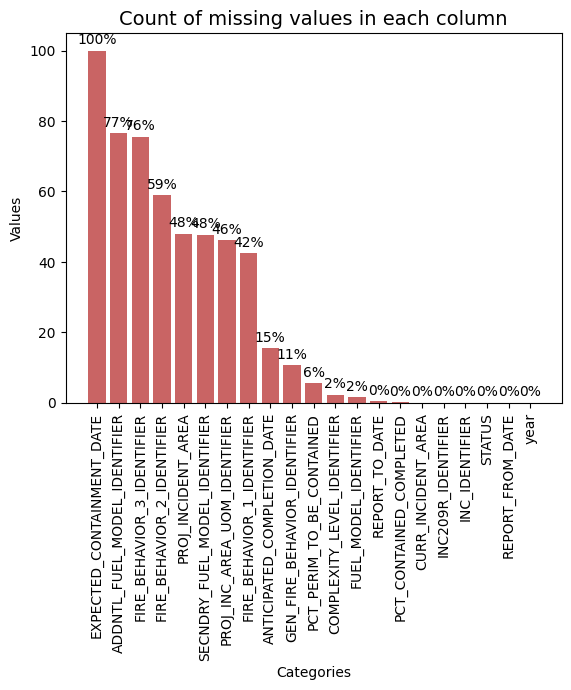

In [26]:
nan_pct= (((reports.isna().sum()/len(reports)*100).sort_values(ascending=False)).round(2))

bars = plt.bar(nan_pct.index, nan_pct.values, alpha=0.7)
plt.xticks(rotation=90)
# Add labels and a title
plt.xlabel('Categories')
plt.ylabel('Values')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,  # Adjust the vertical position of the label
        f'{height:.0f}%',  # Format the label text (you can customize this)
        ha='center',  # Horizontal alignment
        va='bottom'   # Vertical alignment
    )
plt.title('Count of missing values in each column');

<Axes: title={'center': 'PROJ_INCIDENT_AREA'}, ylabel='Density'>

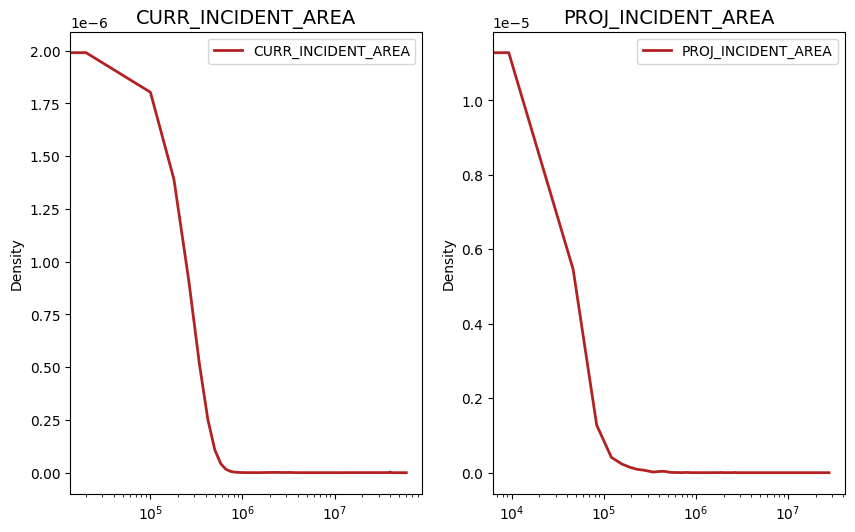

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

col = 'CURR_INCIDENT_AREA'
reports.plot(kind='kde', y=col, title=col, logx=True, ax=axes[0])

col = 'PROJ_INCIDENT_AREA'
reports.plot(kind='kde', y=col, title=col, logx=True, ax=axes[1])

Text(0.5, 1.0, 'KDE plot of PCT_PERIM_TO_BE_CONTAINED')

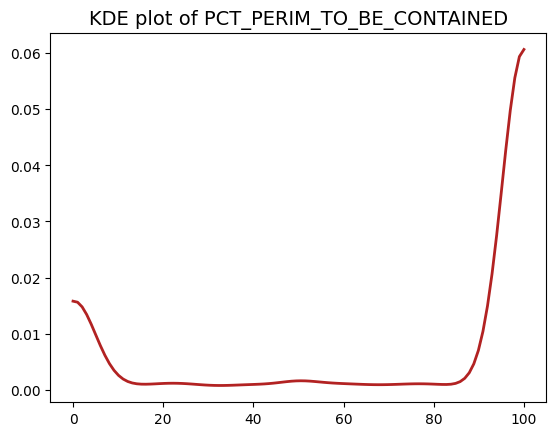

In [29]:
from scipy.stats import gaussian_kde
data = reports["PCT_PERIM_TO_BE_CONTAINED"]
data = data[data.notna()]
kde = gaussian_kde(data)

# Generate x-values for the KDE plot within the specified boundaries
x_values = np.linspace(data.min(), data.max(), 100)

# Calculate the KDE values at each x-value
kde_values = kde(x_values)

# Create a plot for the KDE
plt.plot(x_values, kde_values, label='KDE')
plt.title("KDE plot of PCT_PERIM_TO_BE_CONTAINED")

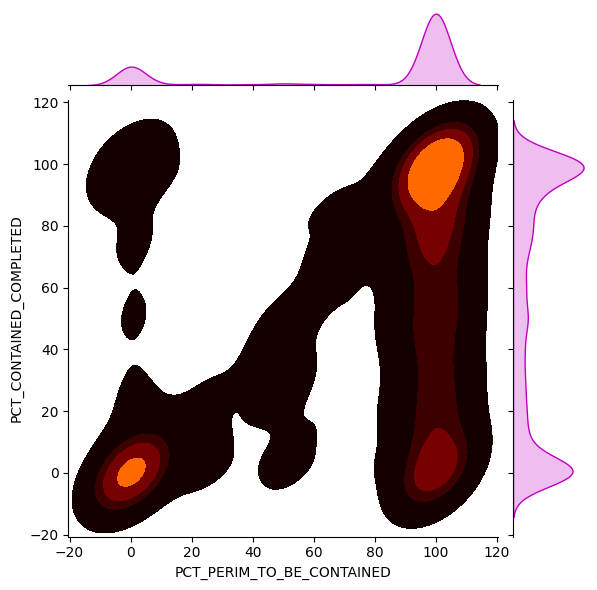

In [30]:
g=sns.jointplot(reports, x="PCT_PERIM_TO_BE_CONTAINED", y="PCT_CONTAINED_COMPLETED", kind="kde", color="m", zorder=0, fill=True, cmap="gist_heat",levels=5)


                    REPORT_FROM_DATE                 REPORT_TO_DATE  \
count                          45389                          45189   
mean   2017-01-26 06:08:41.313555968  2017-01-29 20:14:47.092876800   
min              2012-11-15 13:00:00            2012-11-25 15:00:00   
25%              2015-11-18 10:00:00            2016-01-18 16:00:00   
50%              2017-03-22 15:00:00            2017-03-25 18:30:00   
75%              2017-11-16 15:00:00            2017-11-27 10:00:00   
max              2018-12-25 12:00:00            2018-12-26 12:00:00   
std                              NaN                            NaN   

       CURR_INCIDENT_AREA  PCT_CONTAINED_COMPLETED  PROJ_INCIDENT_AREA  \
count        4.537300e+04             45334.000000        2.361000e+04   
mean         9.094782e+04                54.203666        2.291331e+04   
min          0.000000e+00                 0.000000        0.000000e+00   
25%          2.700000e+02                 8.000000        4.0000

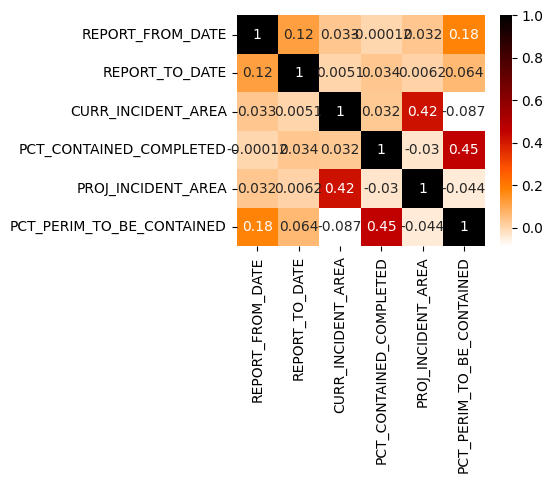

In [31]:
num_cols = reports.describe().columns
print(reports[num_cols[2:]].describe())
plt.figure(figsize=(4,3))
sns.heatmap(reports[num_cols[2:]].corr(), annot=True, cmap="gist_heat_r");

In [32]:
(reports[num_cols[2:]].isna().sum()/len(reports)*100).to_frame().T

,REPORT_FROM_DATE,REPORT_TO_DATE,CURR_INCIDENT_AREA,PCT_CONTAINED_COMPLETED,PROJ_INCIDENT_AREA,PCT_PERIM_TO_BE_CONTAINED
0,0.0,0.440635,0.035251,0.121175,47.982991,5.552006


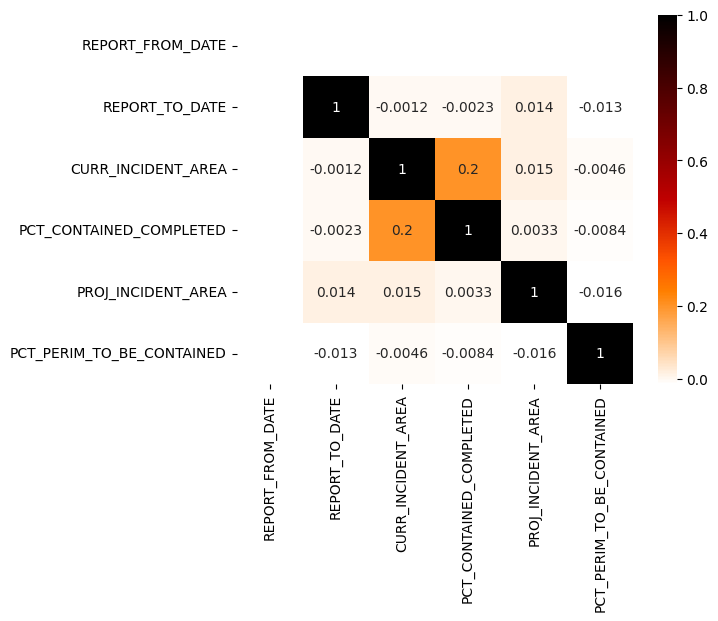

In [33]:

sns.heatmap(reports[num_cols[2:]].isna().corr(), annot=True, cmap="gist_heat_r");

count    7823.000000
mean        5.801994
std         9.806047
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max       179.000000
Name: count, dtype: float64


<Axes: title={'center': 'Number of reports per incidents'}, ylabel='Frequency'>

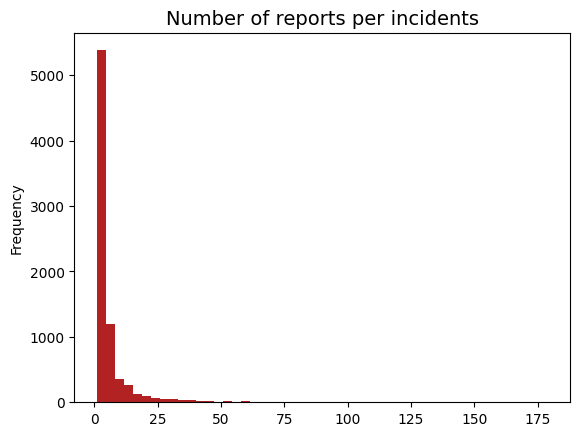

In [34]:
print(reports["INC_IDENTIFIER"].value_counts().describe())
reports["INC_IDENTIFIER"].value_counts().plot(kind="hist", bins=50, title="Number of reports per incidents")

In [39]:
reports.sort_values(by=['INC_IDENTIFIER', 'REPORT_FROM_DATE'], inplace=True)

In [54]:
reports.columns

Index(['INC209R_IDENTIFIER', 'INC_IDENTIFIER', 'REPORT_FROM_DATE',
       'REPORT_TO_DATE', 'STATUS', 'CURR_INCIDENT_AREA',
       'PCT_CONTAINED_COMPLETED', 'COMPLEXITY_LEVEL_IDENTIFIER',
       'FUEL_MODEL_IDENTIFIER', 'PROJ_INCIDENT_AREA',
       'PROJ_INC_AREA_UOM_IDENTIFIER', 'ANTICIPATED_COMPLETION_DATE',
       'EXPECTED_CONTAINMENT_DATE', 'PCT_PERIM_TO_BE_CONTAINED',
       'SECNDRY_FUEL_MODEL_IDENTIFIER', 'ADDNTL_FUEL_MODEL_IDENTIFIER',
       'GEN_FIRE_BEHAVIOR_IDENTIFIER', 'FIRE_BEHAVIOR_1_IDENTIFIER',
       'FIRE_BEHAVIOR_2_IDENTIFIER', 'FIRE_BEHAVIOR_3_IDENTIFIER', 'year'],
      dtype='object')

In [73]:
reports[reports['INC_IDENTIFIER']==reports['INC_IDENTIFIER'].unique()[10]]

,INC209R_IDENTIFIER,INC_IDENTIFIER,REPORT_FROM_DATE,REPORT_TO_DATE,STATUS,CURR_INCIDENT_AREA,PCT_CONTAINED_COMPLETED,COMPLEXITY_LEVEL_IDENTIFIER,FUEL_MODEL_IDENTIFIER,PROJ_INCIDENT_AREA,...,ANTICIPATED_COMPLETION_DATE,EXPECTED_CONTAINMENT_DATE,PCT_PERIM_TO_BE_CONTAINED,SECNDRY_FUEL_MODEL_IDENTIFIER,ADDNTL_FUEL_MODEL_IDENTIFIER,GEN_FIRE_BEHAVIOR_IDENTIFIER,FIRE_BEHAVIOR_1_IDENTIFIER,FIRE_BEHAVIOR_2_IDENTIFIER,FIRE_BEHAVIOR_3_IDENTIFIER,year
28,2714432,2714431,2015-05-17 16:00:00,2015-05-17 18:00:00,I,0.1,100.0,1535968.0,1535987.0,NaN,...,NaN,NaN,100.0,NaN,NaN,1536370.0,NaN,NaN,NaN,2015
29,2714442,2714431,2015-05-19 09:00:00,2015-05-19 17:00:00,U,0.1,100.0,1535968.0,1535987.0,NaN,...,NaN,NaN,100.0,NaN,NaN,1536370.0,NaN,NaN,NaN,2015
30,2714452,2714431,2015-05-19 19:00:00,2015-05-19 20:00:00,F,0.1,100.0,1535968.0,1535987.0,NaN,...,NaN,NaN,100.0,NaN,NaN,1536370.0,NaN,NaN,NaN,2015


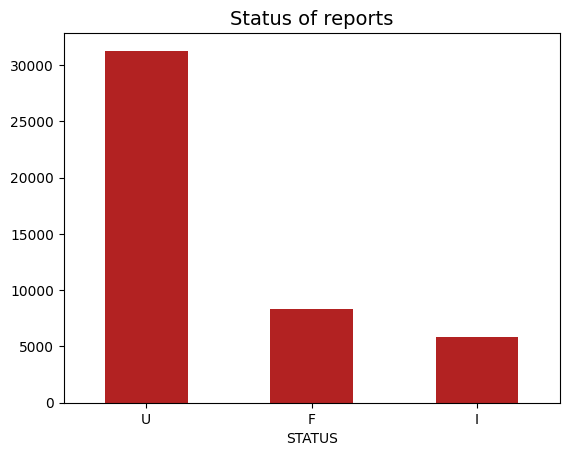

In [66]:
reports.STATUS.value_counts().plot(kind="bar", title="Status of reports")
plt.xticks(rotation=0);

## Incidents

In [56]:
pivot_df = pd.pivot_table(resources,
                          values=['RESOURCE_QUANTITY', 'RESOURCE_PERSONNEL'],
                          index=['INC209R_IDENTIFIER'],
                          columns=['resource'],
                          aggfunc='sum',
                          fill_value=0)

# Flatten the multi-level column index
pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]

# Reset index to make it look like a regular DataFrame
pivot_df.reset_index(inplace=True)

<Axes: title={'center': 'Total resources used'}>

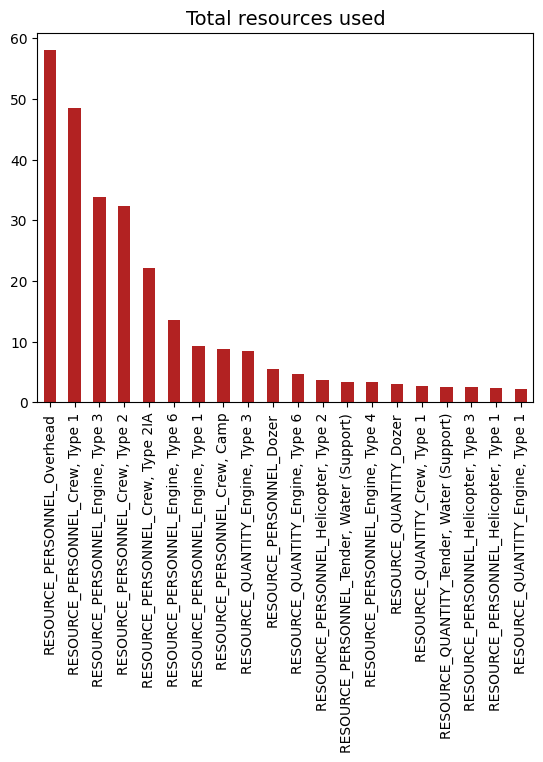

In [57]:
(pivot_df.iloc[:, 1:].mean(axis=0)).sort_values(ascending=False)[:20].plot(kind="bar", title="Total resources used")

<Axes: title={'center': 'Number of personnel per report'}, ylabel='Frequency'>

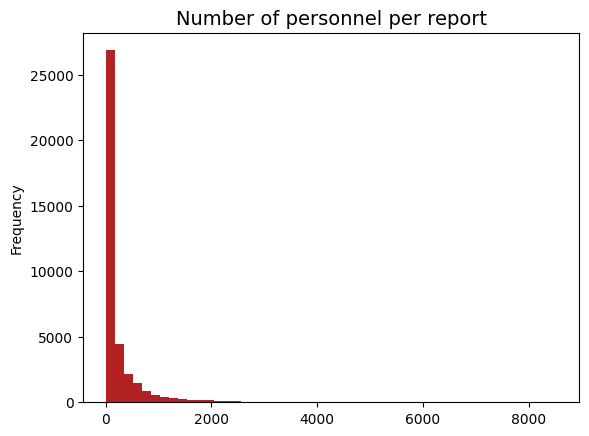

In [46]:
personnel = resources.groupby("INC209R_IDENTIFIER")["RESOURCE_PERSONNEL"].sum()
personnel.plot(kind="hist", bins=50, title="Number of personnel per report")

In [66]:
date_cols = [col for col in merged.columns if "DATE" in col]

In [68]:
df = merged[["IRWIN_IDENTIFIER", "INCIDENT_IDENTIFIER", "INC209R_IDENTIFIER", "CURR_INCIDENT_AREA"]+date_cols].merge(personnel, on="INC209R_IDENTIFIER", how="inner")

In [69]:
float_cols = [col for col, dtype in df.dtypes.items() if dtype == 'float64']
corr_matrix = df[float_cols].corr()
corr_matrix

,INCIDENT_IDENTIFIER,CURR_INCIDENT_AREA,RESOURCE_PERSONNEL
INCIDENT_IDENTIFIER,1.000000,0.044278,0.032430
CURR_INCIDENT_AREA,0.044278,1.000000,0.000653
RESOURCE_PERSONNEL,0.032430,0.000653,1.000000


In [71]:
df.to_csv("personnel_date.csv", index=False)

In [58]:
print(df["IRWIN_IDENTIFIER"].value_counts().describe()) #incidents
print(df["INCIDENT_IDENTIFIER"].value_counts().describe()) #reports
print(df["INC209R_IDENTIFIER"].value_counts().describe()) #ressources

count    5706.000000
mean        6.604802
std        10.926652
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max       179.000000
Name: count, dtype: float64
count    5906.000000
mean        6.519641
std        10.699104
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max       179.000000
Name: count, dtype: float64
count    38505.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: count, dtype: float64


In [59]:
df.groupby("INCIDENT_IDENTIFIER")[["CURR_INCIDENT_AREA", "RESOURCE_PERSONNEL"]]

In [ ]:
##